In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from loadmodules import *

In [2]:
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4' in directory]

In [5]:
def get_massloss_rates(simulation, low_limit=None, high_limit=None):
    sf = load_subfind(127, dir=simulation+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(127, snappath=simulation+'/output/', hdf5=True, subfind=sf, loadonlyhalo=0, loadonlytype=[4] )
    s.calc_sf_indizes( sf )
    galrad = 0.1 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10
    s.data['imcl'] *= 1e10
    s.data['mlsk'] *= 1e10
    s.data['mlrx'] *= 1e10

    s.data['r'] = np.sqrt(np.sum((s.data['pos'])**2, axis=1))

    mask_clusters_initial = (s.data['incl'] > 0 )
    
    init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
    mlost_shocks = s.data['mlsk'][mask_clusters_initial].flatten()
    mlost_rlx = s.data['mlrx'][mask_clusters_initial].flatten()
    disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0)

    init_cluster_masses = init_cluster_masses[not_empty_clusters]
    disruption_time = disruption_time[not_empty_clusters]
    mlost_shocks = mlost_shocks[not_empty_clusters]
    mlost_rlx = mlost_rlx[not_empty_clusters]

    mlost_total = mlost_shocks + mlost_rlx
    
    clusters_formtime = np.repeat(s.data['age'][mask_clusters_initial], s.data['incl'][mask_clusters_initial])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)
    
    if (low_limit is None) and (high_limit is None):
        mass_constrain = np.ones_like(init_cluster_masses, dtype=bool)
    elif (low_limit is None) and (high_limit is not None):
        mass_constrain = (init_cluster_masses < high_limit)
    elif (high_limit is None) and (low_limit is not None):
        mass_constrain = (init_cluster_masses>low_limit)
    else:
        mass_constrain = (init_cluster_masses>low_limit) * (init_cluster_masses < high_limit)

    lifetime = np.zeros_like(init_cluster_masses[mass_constrain])
    mask_disrupted = (disruption_time[mass_constrain]>0.)
    lifetime[mask_disrupted] = clusters_age[mass_constrain][mask_disrupted] - s.cosmology_get_lookback_time_from_a(disruption_time[mass_constrain][mask_disrupted], is_flat=True)
    
    mlossrate_shocks = np.zeros_like(init_cluster_masses[mass_constrain])
    mlossrate_rlx = np.zeros_like(init_cluster_masses[mass_constrain])
    mlossrate_total = np.zeros_like(init_cluster_masses[mass_constrain])
    
    mlossrate_shocks[~mask_disrupted] = mlost_shocks[mass_constrain][~mask_disrupted]/(1e3*clusters_age[mass_constrain][~mask_disrupted])
    mlossrate_rlx[~mask_disrupted] = mlost_rlx[mass_constrain][~mask_disrupted]/(1e3*clusters_age[mass_constrain][~mask_disrupted])
    mlossrate_total[~mask_disrupted] = mlost_total[mass_constrain][~mask_disrupted]/(1e3*clusters_age[mass_constrain][~mask_disrupted])

    mlossrate_shocks[mask_disrupted] = mlost_shocks[mass_constrain][mask_disrupted]/(1e3*lifetime[mask_disrupted])
    mlossrate_rlx[mask_disrupted] = mlost_rlx[mass_constrain][mask_disrupted]/(1e3*lifetime[mask_disrupted])
    mlossrate_total[mask_disrupted] = mlost_total[mass_constrain][mask_disrupted]/(1e3*lifetime[mask_disrupted])

    return [mlossrate_total, mlossrate_shocks, mlossrate_rlx]

In [6]:
mlossrates_all = get_massloss_rates(simulation_list[3])
mlossrates_low = get_massloss_rates(simulation_list[3], high_limit=1e5)
mlossrates_intermediate = get_massloss_rates(simulation_list[3], low_limit=1e5, high_limit=1e6)
mlossrates_high = get_massloss_rates(simulation_list[3], low_limit=1e6)

/storage/home/can35/can35007/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.


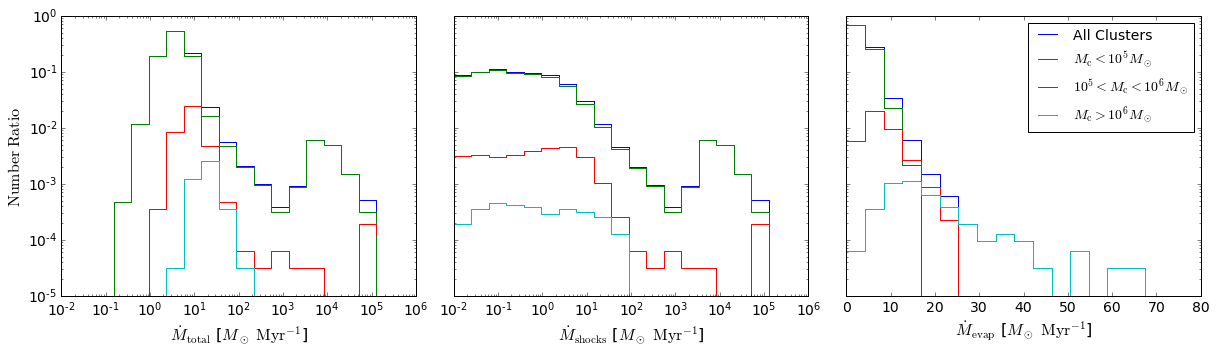

In [7]:
logbins = np.logspace(-2,5.5,20)
linearbins = np.linspace(0,80,20)
fig, ax = plt.subplots(1,3, figsize=(17,5), sharey=True)
N, _ = np.histogram(mlossrates_all[0], bins=logbins)
ax[0].step(logbins[:-1], N/len(mlossrates_all[0]), where='post', label='All Clusters')
N, _ = np.histogram(mlossrates_low[0], bins=logbins)
ax[0].step(logbins[:-1], N/len(mlossrates_all[0]), where='post', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[0], bins=logbins)
ax[0].step(logbins[:-1], N/len(mlossrates_all[0]), where='post', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[0], bins=logbins)
ax[0].step(logbins[:-1], N/len(mlossrates_all[0]), where='post', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel(r'$\dot{M}_{\rm{total}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)
ax[0].set_ylabel(r'$\rm{Number \; Ratio}$', fontsize=16)

N, _ = np.histogram(mlossrates_all[1], bins=logbins)
ax[1].step(logbins[:-1], N/len(mlossrates_all[1]), where='post', label='All Clusters')
N, _ = np.histogram(mlossrates_low[1], bins=logbins)
ax[1].step(logbins[:-1], N/len(mlossrates_all[1]), where='post', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[1], bins=logbins)
ax[1].step(logbins[:-1], N/len(mlossrates_all[1]), where='post', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[1], bins=logbins)
ax[1].step(logbins[:-1], N/len(mlossrates_all[1]), where='post', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel(r'$\dot{M}_{\rm{shocks}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)

N, _ = np.histogram(mlossrates_all[2], bins=linearbins)
ax[2].step(linearbins[:-1], N/len(mlossrates_all[2]), where='post', label='All Clusters')
N, _ = np.histogram(mlossrates_low[2], bins=linearbins)
ax[2].step(linearbins[:-1], N/len(mlossrates_all[2]), where='post', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[2], bins=linearbins)
ax[2].step(linearbins[:-1], N/len(mlossrates_all[2]), where='post', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[2], bins=linearbins)
ax[2].step(linearbins[:-1], N/len(mlossrates_all[2]), where='post', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[2].legend(fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_xlabel(r'$\dot{M}_{\rm{evap}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)

plt.tight_layout()
# plt.savefig('plots/'+simulation_list[3]+'_masslossrates.pdf')